In [1]:
from pathlib import Path
from os.path import expanduser
from os import path
import numpy as np
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import os


In [2]:
root_folder = os.path.dirname(os.getcwd())
path_to_recording= path.join(root_folder,'data/recording_datasets/datasets_rec.npy');
path_to_model = path.join(root_folder, 'models/resnet18_num_classes_2_epoch_6.pt')
path_to_results = path.join(root_folder, 'data/results/datasets_1_results.npy')

sys.path.append(root_folder)
from custom_resnet import CustomResnet as cnn

In [3]:
waveform_length = 72;
step_size = int(np.round(waveform_length * 0.1))
batch_size = 60000;
num_classes = 2;
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = cnn.resnet18(num_classes=num_classes);
checkpoint = torch.load(path_to_model)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device);


In [85]:
transform = transforms.Compose([cnn.FilterSignalUsingButtersWorth('high', 24000, np.array([100], dtype=int), 1), cnn.MovingWeightedMeanAndStdNormalization(1000)])
recording = cnn.Recording(path_to_recording, transform = transform);
recording = cnn.AddPaddingToRecording(recording, step_size, waveform_length)
recording1 = cnn.Recording(path_to_recording, transform = transforms.Compose([cnn.MovingWeightedMeanAndStdNormalization(1000)]));
recording2 = cnn.Recording(path_to_recording);



53434368
53434368


In [5]:
np.mean(recording.data.numpy().ravel())

1.7610566e-09

In [6]:
np.std(recording.data.numpy().ravel())

1.0069314

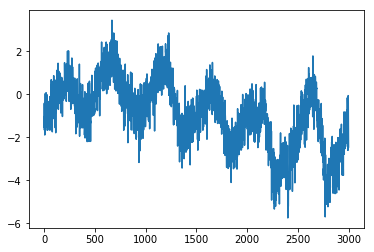

In [92]:
import matplotlib.pyplot as plt
plt.plot(recording1.data[0,0:3000].numpy().ravel())

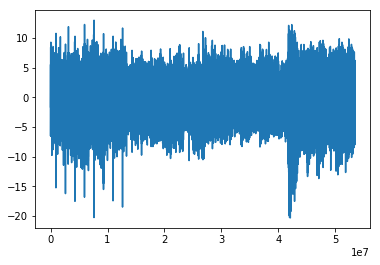

In [8]:
plt.plot(recording1.data.numpy().ravel())

In [9]:
waveform_indices = cnn.GetWaveformIndices(recording, step_size, waveform_length)

In [10]:
transform = transforms.Compose([cnn.ExtractWaveforms(waveform_indices, waveform_length)])
waveforms = transform(recording.data);



In [11]:
normalized_waveforms = waveforms;
dataset_to_infer = cnn.InferenceDataset(normalized_waveforms.to(device));

torch.cuda.FloatTensor


In [12]:
%pdb off
data_loader = torch.utils.data.DataLoader(dataset_to_infer, batch_size=batch_size, shuffle=False, num_workers=0);
result = cnn.Inference(model, data_loader, num_classes)

Automatic pdb calling has been turned OFF
done:  0  batch
done:  1  batch
done:  2  batch
done:  3  batch
done:  4  batch
done:  5  batch
done:  6  batch
done:  7  batch
done:  8  batch
done:  9  batch
done:  10  batch
done:  11  batch
done:  12  batch
done:  13  batch
done:  14  batch
done:  15  batch
done:  16  batch
done:  17  batch
done:  18  batch
done:  19  batch
done:  20  batch
done:  21  batch
done:  22  batch
done:  23  batch
done:  24  batch
done:  25  batch
done:  26  batch
done:  27  batch
done:  28  batch
done:  29  batch
done:  30  batch
done:  31  batch
done:  32  batch
done:  33  batch
done:  34  batch
done:  35  batch
done:  36  batch
done:  37  batch
done:  38  batch
done:  39  batch
done:  40  batch
done:  41  batch
done:  42  batch
done:  43  batch
done:  44  batch
done:  45  batch
done:  46  batch
done:  47  batch
done:  48  batch
done:  49  batch
done:  50  batch
done:  51  batch
done:  52  batch
done:  53  batch
done:  54  batch
done:  55  batch
done:  56  batch

In [13]:
soft_max = nn.Softmax(1)
probability = soft_max(result)
argmax = torch.argmax(probability, 1);


In [14]:
def predictionByTreshold(result, treshold):
  soft_max = nn.Softmax(1)
  probability = soft_max(result)
  prediction = torch.argmax(probability, 1);
  for i  in range(prediction.nelement()):
    if prediction[i] > 0:
      score = probability[i, prediction[i]];
      if(score < treshold):
        prediction[i] = 0;
  return prediction;

In [15]:
treshold = 0.9;
predictions = predictionByTreshold(result, treshold)

In [61]:
waveforms[pred_ind, :, :,].shape

torch.Size([82884, 1, 72])

In [44]:
pred_ind = np.where(predictions == 1)[0];
waveform_start = waveform_indices[0, pred_ind] - waveform_length // 2;
waveform_argmax = np.argmax(abs(waveforms[pred_ind, :, :,]), axis=2);
predicted_index = np.unique(waveform_start + waveform_argmax.view(-1).to(torch.int32));

In [45]:

difference = np.diff(predicted_index);
arg_min = np.argmin(difference);
val_min = np.min(difference)
while (val_min < waveform_length):
    isuppr = np.argmin(abs(recording.data[0,predicted_index[arg_min:arg_min+2]]));
    predicted_index = np.concatenate( ( predicted_index[:arg_min+isuppr], predicted_index[arg_min+isuppr+1:] ) )
    difference = np.diff(predicted_index);
    arg_min = np.argmin(difference);
    val_min = np.min(difference)


In [62]:
print(np.where(predictions == 1)[0].shape)
print(np.where(predictions == 0)[0].shape)

(82884,)
(7550587,)


In [47]:
predicted_index

array([    2460,     6264,     8764, ..., 53429749, 53431146, 53433359],
      dtype=int32)

In [48]:
print(np.where(argmax == 1)[0].shape)
print(np.where(argmax == 0)[0].shape)

(195788,)
(7437683,)


In [21]:
#for seq in extracted_sequences:
#  print(len(seq))

In [49]:
path_to_ground_truth_data = path.join(root_folder,'data/recording_datasets/ground_truth_rec.npy');
ground_truth = np.load(path_to_ground_truth_data);
neuron_indexes = ground_truth[1, :];
spike_positions = ground_truth[0, :];
spike_positions = spike_positions.astype(int)

spike_positions.shape
total = spike_positions.size
print(total)


5402


In [55]:
max_index_unique = predicted_index


In [56]:
spike_positions

array([   12994,    14700,    58288, ..., 20300599,  8397519, 20755754])

In [58]:
max_index_unique

array([    2460,     6264,     8764, ..., 53429749, 53431146, 53433359],
      dtype=int32)

In [39]:
recording1.data[0, 12994 -36: 12994+36]

tensor([-3.4814, -3.1485, -3.6604, -2.6615, -2.2935, -3.8019, -4.3343, -3.0087,
        -2.2381, -2.8035, -2.9866, -2.3246, -2.7524, -3.2407, -2.5313, -2.5892,
        -2.2745, -1.9191, -3.1869, -2.1379, -2.1094, -3.1210, -2.8409, -2.5277,
        -3.6103, -3.0175, -2.2945, -1.4349, -1.5226, -1.9087, -1.6753, -2.0002,
        -2.5162, -2.5461, -4.2250, -6.4950, -6.0864, -5.2384, -5.4999, -4.1241,
        -3.6991, -4.5180, -3.7130, -2.1906, -4.0797, -3.1407, -1.4005, -1.7034,
        -2.0832, -2.7330, -1.4005, -1.4229, -1.4178, -0.5931, -0.7814, -0.9308,
        -1.3182, -1.8570, -0.7085, -0.9482, -0.9603, -0.1598, -1.1455, -1.2776,
        -2.0357, -1.7690, -1.1091, -1.5901, -1.5026, -1.0022, -1.0909, -1.4733])

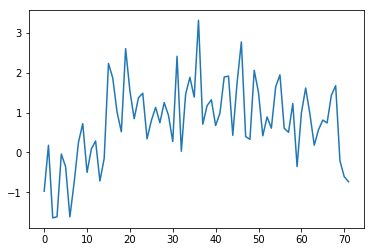

In [81]:
rnd = np.random.randint(0, max_index_unique.size)
plt.plot(recording.data[0, max_index_unique[rnd] -36: max_index_unique[rnd]+36].numpy().ravel())

In [78]:
print(max_index_unique.shape)
np.save(path_to_results, max_index_unique)

(14090,)


In [79]:
is_found = np.zeros(max_index_unique.size)
for i in range(0, max_index_unique.size):
  found = np.where(max_index_unique[i] == spike_positions)
  if(len(found[0]) == 0):
    is_found[i] = 0
  else:
    is_found[i] = 1;

In [80]:
tp = np.where(is_found == 1)[0].size
print(tp)
fp = np.where(is_found == 0)[0].size
print(fp)


3209
10881


In [83]:
np.std(recording.data[0, :].numpy().ravel())

1.0069314

In [27]:
tp

88

In [63]:
tp / total

0.5940392447241762

In [29]:
transform1.append(FilterSignalUsingButtersWorth('high', 24000, np.array([100], dtype=int), 1))


NameError: name 'transform1' is not defined

In [ ]:
# tp is spike
# fp is noise but predicted as spike
# tn is noise
# fn is spike but predicted as noise